In [58]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import plotly.express as px

In [2]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)

## Reding Data

In [3]:
all_data = pd.read_pickle('data_preprocessed/morbilidad_global_2018_lima.pkl')

In [4]:
# Colors
diagnostics_tag = list(set(all_data['DISEASE_GROUP']))
cmap = cm.get_cmap('tab20b', 256)
colorsb = cmap(np.linspace(0, 1, 20))
cmap = cm.get_cmap('tab20c', 256)
colorsc = cmap(np.linspace(0, 1, 20))[8:-4]

colors = list(colorsc)+list(colorsb)
dict_colors = {}
counter = 0
for d in diagnostics_tag:
    x=colors[counter]
    dict_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

In [5]:
# Number of hospital
hospitals_df = all_data.groupby(['DATE', 'CATEGORY2', 'SECTOR_R',
                                 'CO_IPRESS']).agg(QTY_PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'))
hospitals_df = hospitals_df.reset_index()
hospitals_df = hospitals_df.groupby(['DATE', 'CATEGORY2',
                                     'SECTOR_R']).agg(QTY_HOSPITALS=('CO_IPRESS', 'count'),
                                                      QTY_PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'))
hospitals_df = hospitals_df.reset_index()

# Number of Diagnosis
diagnosis_df = all_data.groupby(['DATE', 'CATEGORY2', 'SECTOR_R',
                                 'DIAGNOSIS_ID']).agg(QTY_PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'))
diagnosis_df = diagnosis_df.reset_index()
diagnosis_df = diagnosis_df.groupby(['DATE', 'CATEGORY2',
                                     'SECTOR_R']).agg(QTY_DIAGNOSIS=('DIAGNOSIS_ID', 'count'),
                                                      QTY_PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'))
diagnosis_df = diagnosis_df.reset_index()

# Number of People per Category, Sex and Hospytal
people_df = all_data.groupby(['DATE', 'CATEGORY2', 'SECTOR_R', 'CO_IPRESS', 'SEX',
                              'DIAGNOSIS_ID']).agg(QTY_RECORDS=('QTY_PEOPLE_SERVED', 'count'),
                                                   QTY_PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'))
people_df = people_df.reset_index()

people_df = people_df.groupby(['DATE', 'CATEGORY2', 'SECTOR_R', 'CO_IPRESS',
                               'SEX']).agg(PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'),
                                           UNIQUE_DIAGNOSIS=('QTY_PEOPLE_SERVED', 'count'),
                                           TOTAL_DIAGNOSIS=('QTY_RECORDS', 'sum'))
people_df = people_df.reset_index()
people_df = people_df.sort_values(by=['DATE', 'CATEGORY2', 'SECTOR_R','CO_IPRESS', 'SEX'], ascending=False)
people_df = people_df.reset_index(drop=True)

# List of hospitals
hospitals_list_df =  all_data.groupby(['DATE', 'CATEGORY2', 'SECTOR_R', 'SEX',
                                       'CO_IPRESS']).agg(ABC=('DISEASE_GROUP', 'count'))
hospitals_list_df = hospitals_list_df.reset_index()
hospitals_list_df = hospitals_list_df.groupby(['DATE', 'CATEGORY2', 'SECTOR_R', 
                                               'SEX'])['CO_IPRESS'].apply(list).reset_index(name='HOSPITALS')
hospitals_list_df = hospitals_list_df.sort_values(by=['DATE', 'SECTOR_R', 'SEX'], ascending=True)
hospitals_list_df = hospitals_list_df.reset_index(drop=True)

## Analysis for Category

In [6]:
TAG_CATEGORY = 'III'

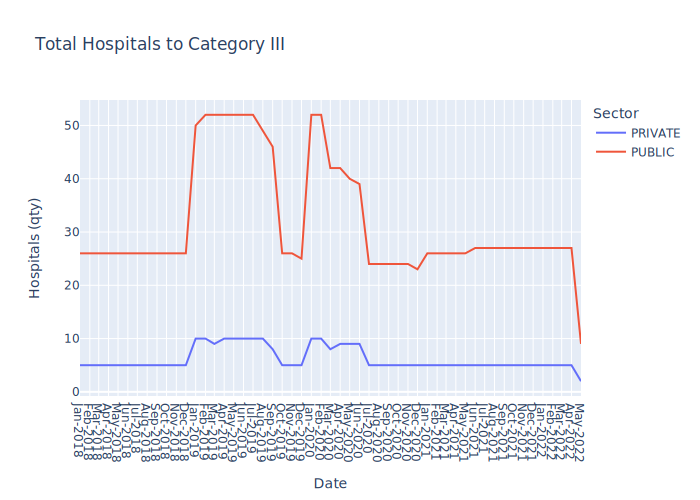

In [25]:
# DF TEMPORAL
data_temp = hospitals_df[(hospitals_df['CATEGORY2']==TAG_CATEGORY)].reset_index(drop=True)

data_temp = data_temp.pivot_table(index=['DATE'],
                                  columns=['SECTOR_R'],
                                  values='QTY_HOSPITALS').fillna(0)
data_temp = data_temp.reset_index().rename_axis(None, axis=1)

# FIGURA
columns_name = list(data_temp.columns)[1:]
fig = px.line(data_temp, 
              x="DATE", 
              y=columns_name,
              hover_data={"DATE": "|%Y %b"},
              labels={
                  "value": "Hospitals (qty)",
                  "DATE": "Date",
                  "variable": "Sector"
              },
              title='Total Hospitals to Category ' + TAG_CATEGORY)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")

fig.show(renderer="svg")
#fig.show()


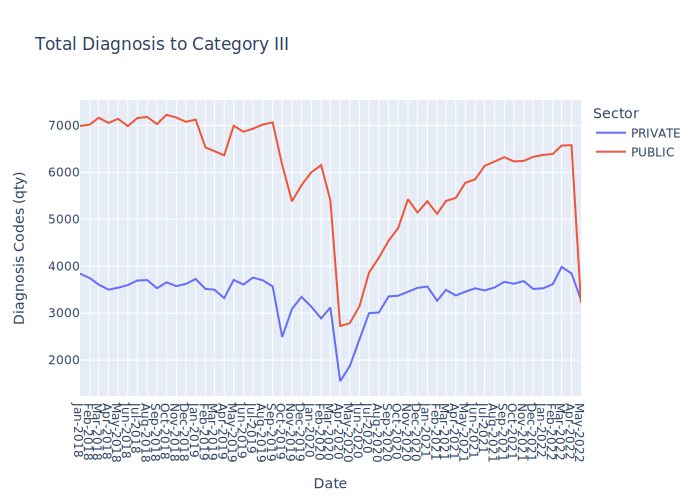

In [26]:
# DF TEMPORAL
data_temp = diagnosis_df[(diagnosis_df['CATEGORY2']==TAG_CATEGORY)].reset_index(drop=True)

data_temp = data_temp.pivot_table(index=['DATE'],
                                  columns=['SECTOR_R'],
                                  values='QTY_DIAGNOSIS').fillna(0)
data_temp = data_temp.reset_index().rename_axis(None, axis=1)

# FIGURA
columns_name = list(data_temp.columns)[1:]
fig = px.line(data_temp, 
              x="DATE", 
              y=columns_name,
              hover_data={"DATE": "|%Y %b"},
              labels={
                     "value": "Diagnosis Codes (qty)",
                     "DATE": "Date",
                     "variable": "Sector"
                 },
              title='Total Diagnosis to Category ' + TAG_CATEGORY)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")

fig.show(renderer="svg")
#fig.show()

### Base Line

In [27]:
start_date = '2019-01-01'
end_date = '2019-09-01'

data_temp = hospitals_list_df[(hospitals_list_df['CATEGORY2']==TAG_CATEGORY)].reset_index(drop=True)
data_temp = data_temp[(data_temp['DATE'] >= start_date) & (data_temp['DATE'] < end_date)].reset_index(drop=True)
del data_temp['CATEGORY2']

# Qty of hospitals per date/sector/sex
dates_hospital_df = []
for date in set(data_temp['DATE']):
    for sector in set(data_temp['SECTOR_R']):
        df_temp = data_temp[(data_temp['DATE']==date) & (data_temp['SECTOR_R']==sector)]
        female = set(df_temp.iloc[0,3])
        male = set(df_temp.iloc[1,3])
        intersection = male & female
        union = male | female
        diference = male ^ female
        only_female = list(female - male)
        only_male =  list(male - female)
        abc = [date, sector, len(female), len(male), len(intersection), len(union), len(diference)]
        dates_hospital_df.append(abc)
        
dates_hospital_df = pd.DataFrame(dates_hospital_df, columns = ['DATE', 'SECTOR_R', 'FEMALE', 'MALE','INTER', 'UNION', 'DIFFERENCE'])
dates_hospital_df = dates_hospital_df.sort_values(by=['DATE', 'SECTOR_R'], ascending=True)

# Qty of people per date/sector/hospital/sex
data_temp = people_df[(people_df['CATEGORY2']==TAG_CATEGORY)].reset_index(drop=True)
data_temp = data_temp[(data_temp['DATE'] >= start_date) & (data_temp['DATE'] < end_date)].reset_index(drop=True)
del data_temp['CATEGORY2']
data_temp = data_temp.sort_values(by=['DATE', 'SECTOR_R','CO_IPRESS', 'SEX'], ascending=True)
data_temp = data_temp.groupby(['DATE', 'SECTOR_R',
                               'SEX']).agg(PEOPLE_SERVED=('PEOPLE_SERVED', 'sum'),
                                           UNIQUE_DIAGNOSIS=('UNIQUE_DIAGNOSIS', 'sum'),
                                           TOTAL_DIAGNOSIS=('TOTAL_DIAGNOSIS', 'sum'))
data_temp = data_temp.reset_index()

### Normalization to All hospitals

In [28]:
PARAMS = 'INTER'
normalized_df = pd.merge(data_temp, dates_hospital_df[['DATE','SECTOR_R',PARAMS]], how='left', on=('DATE','SECTOR_R'))
normalized_df['PEOPLE_SERVED_NORMALIZED'] = normalized_df['PEOPLE_SERVED'] / normalized_df[PARAMS]
normalized_df['UNIQUE_DIAGNOSIS_NORMALIZED'] = normalized_df['UNIQUE_DIAGNOSIS'] / normalized_df[PARAMS]
normalized_df['TOTAL_DIAGNOSIS_NORMALIZED'] = normalized_df['TOTAL_DIAGNOSIS'] / normalized_df[PARAMS]

for a in set(normalized_df.DATE):
    for b in set(normalized_df.SECTOR_R):
        rest_temp_df = normalized_df[(normalized_df.DATE==a) & (normalized_df.SECTOR_R==b)]
        total_resumen = [a,
                         b,
                         'SEX_AVG',
                         rest_temp_df['PEOPLE_SERVED'].mean(),
                         rest_temp_df['UNIQUE_DIAGNOSIS'].mean(),
                         rest_temp_df['TOTAL_DIAGNOSIS'].mean(),
                         rest_temp_df[PARAMS].mean(),
                         rest_temp_df['PEOPLE_SERVED_NORMALIZED'].mean(),
                         rest_temp_df['UNIQUE_DIAGNOSIS_NORMALIZED'].mean(),
                         rest_temp_df['TOTAL_DIAGNOSIS_NORMALIZED'].mean()
                        ]
        normalized_df.loc[len(normalized_df)] = total_resumen
        
for a in set(normalized_df.DATE):
    rest_temp_df = normalized_df[(normalized_df.DATE==a)]
    total_resumen = [a,
                     'TOTAL',
                     'SECTOR_AVG',
                     rest_temp_df['PEOPLE_SERVED'].mean(),
                     rest_temp_df['UNIQUE_DIAGNOSIS'].mean(),
                     rest_temp_df['TOTAL_DIAGNOSIS'].mean(),
                     rest_temp_df[PARAMS].mean(),
                     rest_temp_df['PEOPLE_SERVED_NORMALIZED'].mean(),
                     rest_temp_df['UNIQUE_DIAGNOSIS_NORMALIZED'].mean(),
                     rest_temp_df['TOTAL_DIAGNOSIS_NORMALIZED'].mean()
                    ]
    normalized_df.loc[len(normalized_df)] = total_resumen
                
normalized_df = normalized_df.sort_values(by=['DATE', 'SECTOR_R', 'SEX'], ascending=False)   

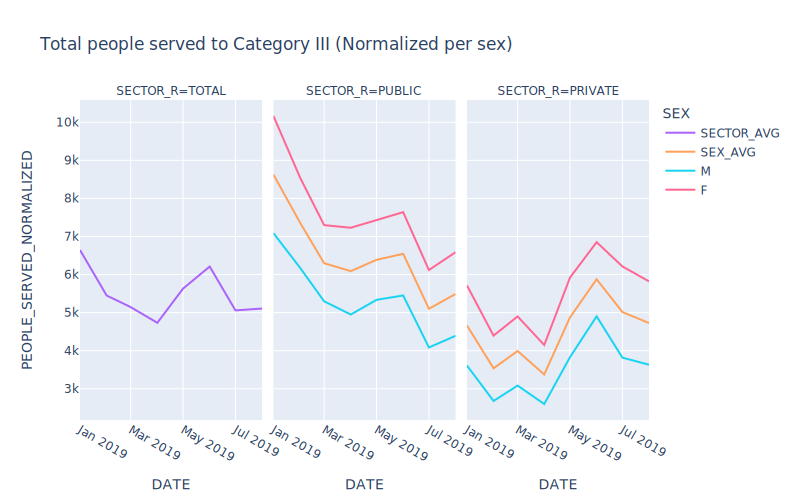

In [35]:
# PEOPLE SERVED
fig = px.line(normalized_df, 
             x="DATE", 
             y="PEOPLE_SERVED_NORMALIZED", 
             color="SEX", 
             facet_col="SECTOR_R",
             width=800, height=500,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + TAG_CATEGORY + ' (Normalized per sex)',
            )

#fig.show()
fig.show(renderer="svg")

### Normalization to During (Apr-May-Jun)

In [36]:
start_date = '2020-04-01'
end_date = '2020-07-01'

hospitals_sector_df = hospitals_list_df[(hospitals_list_df['CATEGORY2']==TAG_CATEGORY)].reset_index(drop=True)
data_temp = hospitals_sector_df[(hospitals_sector_df['DATE'] >= start_date) & (hospitals_sector_df['DATE'] < end_date)].reset_index(drop=True)
del data_temp['CATEGORY2']

# Qty of hospitals per date/sector/sex
dates_hospital_df = []
for date in set(data_temp['DATE']):
    for sector in set(data_temp['SECTOR_R']):
        df_temp = data_temp[(data_temp['DATE']==date) & (data_temp['SECTOR_R']==sector)]
        female = set(df_temp.iloc[0,3])
        male = set(df_temp.iloc[1,3])
        intersection = male & female
        union = male | female
        diference = male ^ female
        only_female = list(female - male)
        only_male =  list(male - female)
        abc = [date, sector, len(female), len(male), len(intersection), len(union), len(diference)]
        dates_hospital_df.append(abc)
        
dates_hospital_df = pd.DataFrame(dates_hospital_df, columns = ['DATE', 'SECTOR_R', 'FEMALE', 'MALE','INTER', 'UNION', 'DIFFERENCE'])
dates_hospital_df = dates_hospital_df.sort_values(by=['DATE', 'SECTOR_R'], ascending=True)

# Qty of people per date/sector/hospital/sex
data_temp = people_df[(people_df['CATEGORY2']==TAG_CATEGORY)].reset_index(drop=True)
data_temp = data_temp[(data_temp['DATE'] >= start_date) & (data_temp['DATE'] < end_date)].reset_index(drop=True)
del data_temp['CATEGORY2']
data_temp = data_temp.sort_values(by=['DATE', 'SECTOR_R','CO_IPRESS', 'SEX'], ascending=True)
data_temp = data_temp.groupby(['DATE', 'SECTOR_R',
                               'SEX']).agg(PEOPLE_SERVED=('PEOPLE_SERVED', 'sum'),
                                           UNIQUE_DIAGNOSIS=('UNIQUE_DIAGNOSIS', 'sum'),
                                           TOTAL_DIAGNOSIS=('TOTAL_DIAGNOSIS', 'sum'))
data_temp = data_temp.reset_index()

In [37]:
PARAMS = 'INTER'
normalized_df = pd.merge(data_temp, dates_hospital_df[['DATE','SECTOR_R',PARAMS]], how='left', on=('DATE','SECTOR_R'))
normalized_df['PEOPLE_SERVED_NORMALIZED'] = normalized_df['PEOPLE_SERVED'] / normalized_df[PARAMS]
normalized_df['UNIQUE_DIAGNOSIS_NORMALIZED'] = normalized_df['UNIQUE_DIAGNOSIS'] / normalized_df[PARAMS]
normalized_df['TOTAL_DIAGNOSIS_NORMALIZED'] = normalized_df['TOTAL_DIAGNOSIS'] / normalized_df[PARAMS]

for a in set(normalized_df.DATE):
    for b in set(normalized_df.SECTOR_R):
        rest_temp_df = normalized_df[(normalized_df.DATE==a) & (normalized_df.SECTOR_R==b)]
        total_resumen = [a,
                         b,
                         'SEX_AVG',
                         rest_temp_df['PEOPLE_SERVED'].mean(),
                         rest_temp_df['UNIQUE_DIAGNOSIS'].mean(),
                         rest_temp_df['TOTAL_DIAGNOSIS'].mean(),
                         rest_temp_df[PARAMS].mean(),
                         rest_temp_df['PEOPLE_SERVED_NORMALIZED'].mean(),
                         rest_temp_df['UNIQUE_DIAGNOSIS_NORMALIZED'].mean(),
                         rest_temp_df['TOTAL_DIAGNOSIS_NORMALIZED'].mean()
                        ]
        normalized_df.loc[len(normalized_df)] = total_resumen
        
for a in set(normalized_df.DATE):
    rest_temp_df = normalized_df[(normalized_df.DATE==a)]
    total_resumen = [a,
                     'TOTAL',
                     'SECTOR_AVG',
                     rest_temp_df['PEOPLE_SERVED'].mean(),
                     rest_temp_df['UNIQUE_DIAGNOSIS'].mean(),
                     rest_temp_df['TOTAL_DIAGNOSIS'].mean(),
                     rest_temp_df[PARAMS].mean(),
                     rest_temp_df['PEOPLE_SERVED_NORMALIZED'].mean(),
                     rest_temp_df['UNIQUE_DIAGNOSIS_NORMALIZED'].mean(),
                     rest_temp_df['TOTAL_DIAGNOSIS_NORMALIZED'].mean()
                    ]
    normalized_df.loc[len(normalized_df)] = total_resumen
                
normalized_df = normalized_df.sort_values(by=['DATE', 'SECTOR_R', 'SEX'], ascending=False)   

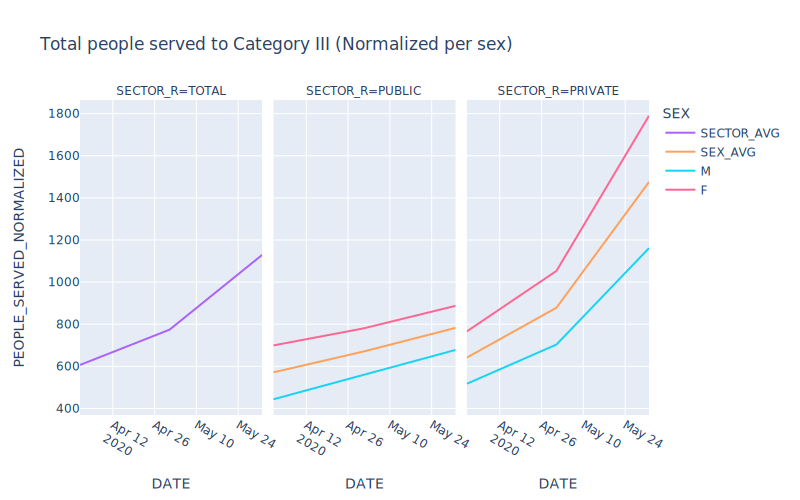

In [38]:
# PEOPLE SERVED
fig = px.line(normalized_df, 
             x="DATE", 
             y="PEOPLE_SERVED_NORMALIZED", 
             color="SEX", 
             facet_col="SECTOR_R",
             width=800, height=500,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + TAG_CATEGORY + ' (Normalized per sex)',
            )


fig.show(renderer="svg")


### Normalization to Hospitals that register Covid pacientes During (Apr-May-Jun)

In [39]:
diagnostics_tag = list(set(all_data['DISEASE_GROUP']))

cmap = cm.get_cmap('tab20b', 256)
colorsb = cmap(np.linspace(0, 1, 20))
cmap = cm.get_cmap('tab20c', 256)
colorsc = cmap(np.linspace(0, 1, 20))[8:-4]

colors = list(colorsc)+list(colorsb)

dict_colors = {}
counter = 0
for d in diagnostics_tag:
    x=colors[counter]
    dict_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

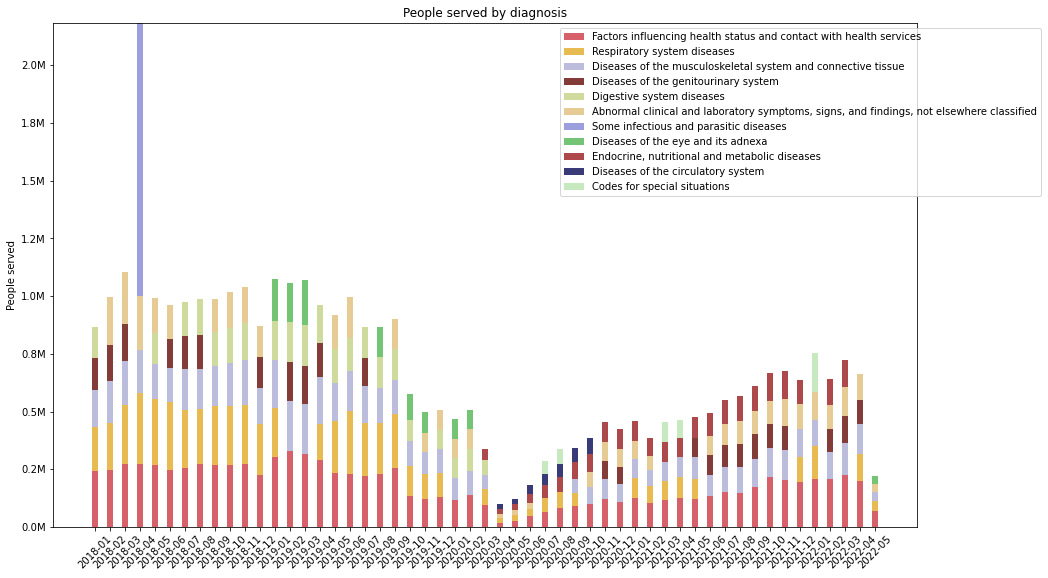

In [40]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.reset_index(drop=True)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()


In [54]:
start_date = '2020-04-01'
end_date = '2020 -07-01'

special_df = all_data[(all_data['DISEASE_GROUP'].isin(['Codes for special situations','Unidentified']))].reset_index(drop=True)
special_df = special_df[(special_df['DATE'] >= start_date) & (special_df['DATE'] < end_date)].reset_index(drop=True)
special_hospitals_list = list(set(special_df['CO_IPRESS']))

special_hospitals_df = all_data[~(all_data['CO_IPRESS'].isin(special_hospitals_list))].reset_index(drop=True)
special_hospitals_df.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,SECTOR_R,CATEGORY,CATEGORY2,...,NAME,SEX,AGE,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,X,Y,TYPE
0,2018-04-01,2018,4,LIMA,LIMA,SAN JUAN DE MIRAFLORES,PRIVADO,PRIVATE,II-1,II,...,CLINICA SANTA MARIA DE LA VIDA,M,1,Z00.1,109,"ENCOUNTER FOR NEWBORN, INFANT AND CHILD HEALTH...",Factors influencing health status and contact ...,NaN,NaN,Outpatient Consultation
1,2018-04-01,2018,4,LIMA,LIMA,SAN JUAN DE MIRAFLORES,PRIVADO,PRIVATE,II-1,II,...,CLINICA SANTA MARIA DE LA VIDA,M,1,A09.0,13,UNIDENTIFIED,Some infectious and parasitic diseases,NaN,NaN,Outpatient Consultation
2,2018-04-01,2018,4,LIMA,LIMA,SAN JUAN DE MIRAFLORES,PRIVADO,PRIVATE,II-1,II,...,CLINICA SANTA MARIA DE LA VIDA,M,1,A09.X,22,UNIDENTIFIED,Some infectious and parasitic diseases,NaN,NaN,Outpatient Consultation
3,2018-04-01,2018,4,LIMA,LIMA,SAN JUAN DE MIRAFLORES,PRIVADO,PRIVATE,II-1,II,...,CLINICA SANTA MARIA DE LA VIDA,M,1,A50.9,10,"CONGENITAL SYPHILIS, UNSPECIFIED",Some infectious and parasitic diseases,NaN,NaN,Outpatient Consultation
4,2018-04-01,2018,4,LIMA,LIMA,SAN JUAN DE MIRAFLORES,PRIVADO,PRIVATE,II-1,II,...,CLINICA SANTA MARIA DE LA VIDA,M,1,D50.9,11,"IRON DEFICIENCY ANEMIA, UNSPECIFIED",Diseases of the blood and hematopoietic organs...,NaN,NaN,Outpatient Consultation


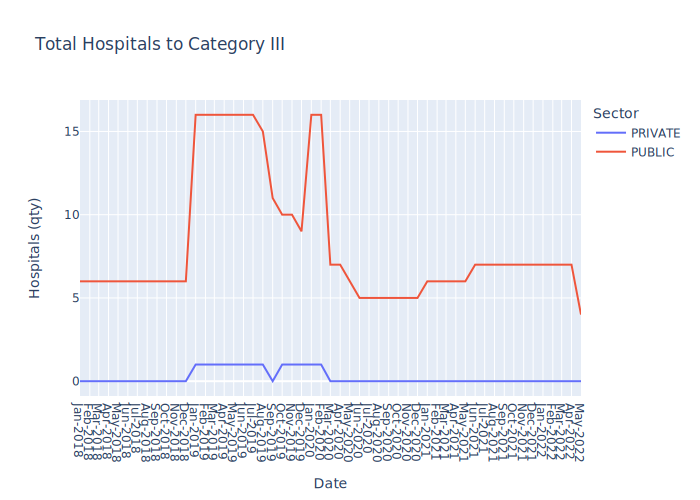

In [60]:
# Number of hospital
hospitals_df = special_hospitals_df.groupby(['DATE', 'CATEGORY2', 'SECTOR_R',
                                 'CO_IPRESS']).agg(QTY_PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'))
hospitals_df = hospitals_df.reset_index()
hospitals_df = hospitals_df.groupby(['DATE', 'CATEGORY2',
                                     'SECTOR_R']).agg(QTY_HOSPITALS=('CO_IPRESS', 'count'),
                                                      QTY_PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'))
hospitals_df = hospitals_df.reset_index()
# DF TEMPORAL
data_temp = hospitals_df[(hospitals_df['CATEGORY2']==TAG_CATEGORY)].reset_index(drop=True)

data_temp = data_temp.pivot_table(index=['DATE'],
                                  columns=['SECTOR_R'],
                                  values='QTY_HOSPITALS').fillna(0)
data_temp = data_temp.reset_index().rename_axis(None, axis=1)

# FIGURA
columns_name = list(data_temp.columns)[1:]
fig = px.line(data_temp, 
              x="DATE", 
              y=columns_name,
              hover_data={"DATE": "|%Y %b"},
              labels={
                  "value": "Hospitals (qty)",
                  "DATE": "Date",
                  "variable": "Sector"
              },
              title='Total Hospitals to Category ' + TAG_CATEGORY)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")

fig.show(renderer="svg")
#fig.show()


In [61]:
# Number of People per Category, Sex and Hospytal
people_df = special_hospitals_df.groupby(['DATE', 'CATEGORY2', 'SECTOR_R', 'CO_IPRESS', 'SEX',
                              'DIAGNOSIS_ID']).agg(QTY_RECORDS=('QTY_PEOPLE_SERVED', 'count'),
                                                   QTY_PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'))
people_df = people_df.reset_index()

people_df = people_df.groupby(['DATE', 'CATEGORY2', 'SECTOR_R', 'CO_IPRESS',
                               'SEX']).agg(PEOPLE_SERVED=('QTY_PEOPLE_SERVED', 'sum'),
                                           UNIQUE_DIAGNOSIS=('QTY_PEOPLE_SERVED', 'count'),
                                           TOTAL_DIAGNOSIS=('QTY_RECORDS', 'sum'))
people_df = people_df.reset_index()
people_df = people_df.sort_values(by=['DATE', 'CATEGORY2', 'SECTOR_R','CO_IPRESS', 'SEX'], ascending=False)
people_df = people_df.reset_index(drop=True)

# List of hospitals
hospitals_list_df =  special_hospitals_df.groupby(['DATE', 'CATEGORY2', 'SECTOR_R', 'SEX',
                                       'CO_IPRESS']).agg(ABC=('DISEASE_GROUP', 'count'))
hospitals_list_df = hospitals_list_df.reset_index()
hospitals_list_df = hospitals_list_df.groupby(['DATE', 'CATEGORY2', 'SECTOR_R', 
                                               'SEX'])['CO_IPRESS'].apply(list).reset_index(name='HOSPITALS')
hospitals_list_df = hospitals_list_df.sort_values(by=['DATE', 'SECTOR_R', 'SEX'], ascending=True)
hospitals_list_df = hospitals_list_df.reset_index(drop=True)

In [69]:
# start_date = '2019-01-01'
# end_date = '2019-09-01'

data_temp = hospitals_list_df[(hospitals_list_df['CATEGORY2']==TAG_CATEGORY)].reset_index(drop=True)
#data_temp = data_temp[(data_temp['DATE'] >= start_date) & (data_temp['DATE'] < end_date)].reset_index(drop=True)
del data_temp['CATEGORY2']

# Qty of hospitals per date/sector/sex
dates_hospital_df = []
for date in set(data_temp['DATE']):
    for sector in set(data_temp['SECTOR_R']):
        df_temp = data_temp[(data_temp['DATE']==date) & (data_temp['SECTOR_R']==sector)]
        try:
            female = set(df_temp.iloc[0,3])
            male = set(df_temp.iloc[1,3])
            intersection = male & female
            union = male | female
            diference = male ^ female
            only_female = list(female - male)
            only_male =  list(male - female)
            abc = [date, sector, len(female), len(male), len(intersection), len(union), len(diference)]
            dates_hospital_df.append(abc)
        except:
            pass
        
dates_hospital_df = pd.DataFrame(dates_hospital_df, columns = ['DATE', 'SECTOR_R', 'FEMALE', 'MALE','INTER', 'UNION', 'DIFFERENCE'])
dates_hospital_df = dates_hospital_df.sort_values(by=['DATE', 'SECTOR_R'], ascending=True)

# Qty of people per date/sector/hospital/sex
data_temp = people_df[(people_df['CATEGORY2']==TAG_CATEGORY)].reset_index(drop=True)
#data_temp = data_temp[(data_temp['DATE'] >= start_date) & (data_temp['DATE'] < end_date)].reset_index(drop=True)
del data_temp['CATEGORY2']
data_temp = data_temp.sort_values(by=['DATE', 'SECTOR_R','CO_IPRESS', 'SEX'], ascending=True)
data_temp = data_temp.groupby(['DATE', 'SECTOR_R',
                               'SEX']).agg(PEOPLE_SERVED=('PEOPLE_SERVED', 'sum'),
                                           UNIQUE_DIAGNOSIS=('UNIQUE_DIAGNOSIS', 'sum'),
                                           TOTAL_DIAGNOSIS=('TOTAL_DIAGNOSIS', 'sum'))
data_temp = data_temp.reset_index()

In [ ]:
dates_hospital_df

In [70]:
PARAMS = 'INTER'
normalized_df = pd.merge(data_temp, dates_hospital_df[['DATE','SECTOR_R',PARAMS]], how='left', on=('DATE','SECTOR_R'))
normalized_df['PEOPLE_SERVED_NORMALIZED'] = normalized_df['PEOPLE_SERVED'] / normalized_df[PARAMS]
normalized_df['UNIQUE_DIAGNOSIS_NORMALIZED'] = normalized_df['UNIQUE_DIAGNOSIS'] / normalized_df[PARAMS]
normalized_df['TOTAL_DIAGNOSIS_NORMALIZED'] = normalized_df['TOTAL_DIAGNOSIS'] / normalized_df[PARAMS]

for a in set(normalized_df.DATE):
    for b in set(normalized_df.SECTOR_R):
        rest_temp_df = normalized_df[(normalized_df.DATE==a) & (normalized_df.SECTOR_R==b)]
        total_resumen = [a,
                         b,
                         'SEX_AVG',
                         rest_temp_df['PEOPLE_SERVED'].mean(),
                         rest_temp_df['UNIQUE_DIAGNOSIS'].mean(),
                         rest_temp_df['TOTAL_DIAGNOSIS'].mean(),
                         rest_temp_df[PARAMS].mean(),
                         rest_temp_df['PEOPLE_SERVED_NORMALIZED'].mean(),
                         rest_temp_df['UNIQUE_DIAGNOSIS_NORMALIZED'].mean(),
                         rest_temp_df['TOTAL_DIAGNOSIS_NORMALIZED'].mean()
                        ]
        normalized_df.loc[len(normalized_df)] = total_resumen
        
for a in set(normalized_df.DATE):
    rest_temp_df = normalized_df[(normalized_df.DATE==a)]
    total_resumen = [a,
                     'TOTAL',
                     'SECTOR_AVG',
                     rest_temp_df['PEOPLE_SERVED'].mean(),
                     rest_temp_df['UNIQUE_DIAGNOSIS'].mean(),
                     rest_temp_df['TOTAL_DIAGNOSIS'].mean(),
                     rest_temp_df[PARAMS].mean(),
                     rest_temp_df['PEOPLE_SERVED_NORMALIZED'].mean(),
                     rest_temp_df['UNIQUE_DIAGNOSIS_NORMALIZED'].mean(),
                     rest_temp_df['TOTAL_DIAGNOSIS_NORMALIZED'].mean()
                    ]
    normalized_df.loc[len(normalized_df)] = total_resumen
                
normalized_df = normalized_df.sort_values(by=['DATE', 'SECTOR_R', 'SEX'], ascending=False)   

In [71]:
normalized_df

,DATE,SECTOR_R,SEX,PEOPLE_SERVED,UNIQUE_DIAGNOSIS,TOTAL_DIAGNOSIS,INTER,PEOPLE_SERVED_NORMALIZED,UNIQUE_DIAGNOSIS_NORMALIZED,TOTAL_DIAGNOSIS_NORMALIZED
249,2022-05-01,TOTAL,SECTOR_AVG,9363.0,963.5,2662.5,4.0,2340.750000,240.875000,665.625000
155,2022-05-01,PUBLIC,SEX_AVG,9363.0,963.5,2662.5,4.0,2340.750000,240.875000,665.625000
131,2022-05-01,PUBLIC,M,9590.0,928.0,2455.0,4.0,2397.500000,232.000000,613.750000
130,2022-05-01,PUBLIC,F,9136.0,999.0,2870.0,4.0,2284.000000,249.750000,717.500000
154,2022-05-01,PRIVATE,SEX_AVG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
272,2018-01-01,TOTAL,SECTOR_AVG,33369.5,2055.0,7720.0,6.0,5561.583333,342.500000,1286.666667
201,2018-01-01,PUBLIC,SEX_AVG,33369.5,2055.0,7720.0,6.0,5561.583333,342.500000,1286.666667
1,2018-01-01,PUBLIC,M,28561.0,2005.0,7338.0,6.0,4760.166667,334.166667,1223.000000
0,2018-01-01,PUBLIC,F,38178.0,2105.0,8102.0,6.0,6363.000000,350.833333,1350.333333


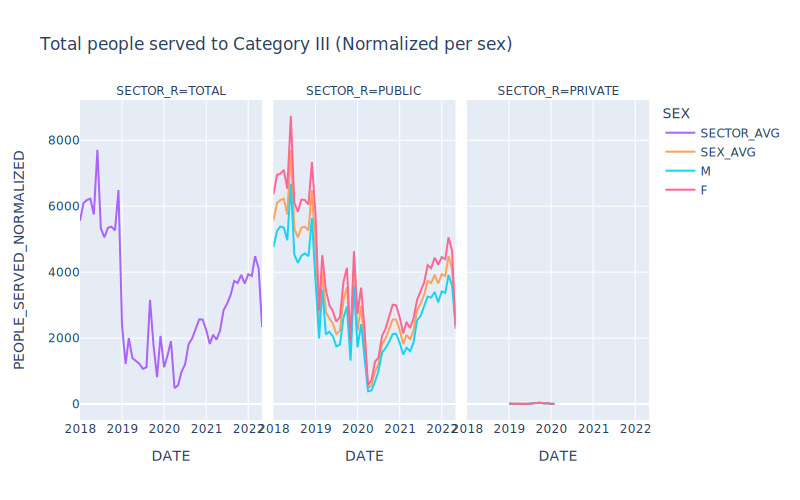

In [72]:
# PEOPLE SERVED
fig = px.line(normalized_df, 
             x="DATE", 
             y="PEOPLE_SERVED_NORMALIZED", 
             color="SEX", 
             facet_col="SECTOR_R",
             width=800, height=500,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + TAG_CATEGORY + ' (Normalized per sex)',
            )

#fig.show()

fig.show(renderer="svg")

### Base line codes hospitals


### FIN